# Membership vector

### Karate club network: A case study in `igraph`
Let's apply the concept of a membership vector to the famous Zachary's Karate Club network. 

First, we'll load the network and then run a community detection algorithm. The algorithm's job is to partition the network's vertices (the club members) into communities, reflecting the real-life split.

In [1]:
import igraph as ig
import random

ig.config["plotting.backend"] = "matplotlib"

# Load the Karate Club network
karate_club = ig.Graph.Famous("Zachary")

# Run the leading_eigenvector algorithm to find communities
communities = karate_club.community_leading_eigenvector()

#### What is the membership vector?

The communities object returned by the algorithm is a VertexClustering object. A core component of this object is its membership vector, which is a list that assigns a community ID to each of the 34 club members.

The length of the vector is 34 (one for each member), and the values are integers representing the communities found.

In [2]:
# Access the membership vector directly
membership_vector = communities.membership

print(membership_vector)

[0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1]


This vector tells us which community each member belongs to. For example, the first member (at index 0) and the fifth member (at index 4) are both in community 0, while the ninth member (at index 8) is in community 1.

### Why is it useful?

The membership vector is the most direct and compact representation of a clustering. It serves as the basis for almost all subsequent analyses and visualizations:

* __Visualization:__ It's used to color vertices in a plot. Vertices with the same membership value are assigned the same color, making the clusters visually distinct.

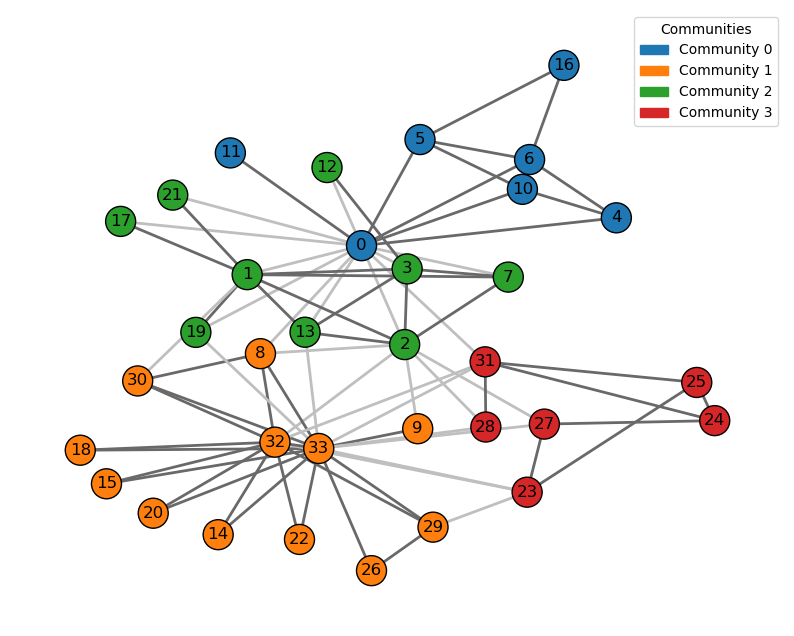

In [3]:
%run -i functions.ipynb
ig_plot_w_legend(karate_club, communities)

* __Data Extraction:__ You can easily get a list of all vertices belonging to a specific cluster by filtering the original vertex list using the membership vector.

In [4]:
karate_club.vs['name'] = [str(i) for i in range(karate_club.vcount())]

# Find the indices of all vertices that belong to community 1
community_1_indices = [i for i, community_id in enumerate(membership_vector) if community_id == 1]

print("Indices of members in Community 1:")
print(community_1_indices) 

Indices of members in Community 1:
[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]


### Membership vector as an input parameter on Stochastic Block Model

We studied membership vectors as an output of the clusterings, but such vectors can easily used as **inputs** of differenct clustering methods, such as the `community_label_propagation()` method, which can take `initial` as an input parameter. By this we can control the maximum number of clusters identified by the method.

First we build the network:

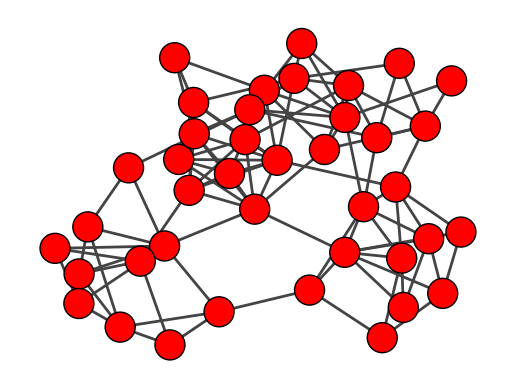

In [5]:
# Define the parameters for the SBM
num_blocks = 3  # Number of communities
block_sizes = [10, 10, 10, 10]  # Number of vertices in each block
num_vertices = sum(block_sizes) # Total number of vertices

p_in = 0.5  # Probability of an edge within a block
p_out = 0.02  # Probability of an edge between blocks

pref_matrix = []
for i in range(len(block_sizes)):
    row = []
    for j in range(len(block_sizes)):
        if i == j:
            row.append(p_in)
        else:
            row.append(p_out)
    pref_matrix.append(row)

g = ig.Graph.SBM(
    n=num_vertices,
    pref_matrix=pref_matrix,
    block_sizes=block_sizes
)

ig.plot(g);

Then, we generate a random initial community structure for the network, with maximum `num_communities` communities

In [6]:
num_nodes = g.vcount() # This will be 34

# Specify the desired number of communities
num_communities = 2
random_membership = [random.randint(0, num_communities - 1) for _ in range(num_nodes)]
print(random_membership)

[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]


Next, we run the `community_label_propagation` method with this randomly generated membership:

0.2819047619047619
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


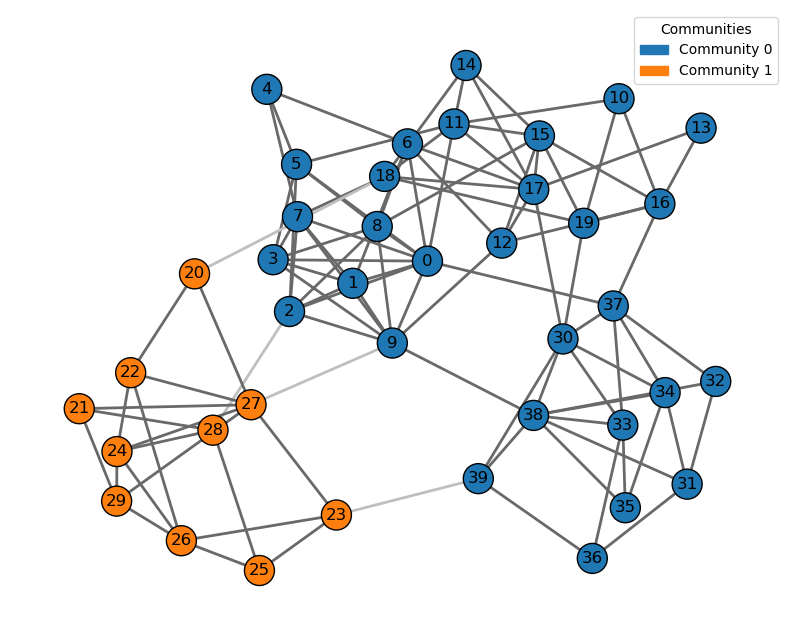

In [7]:
communities = g.community_label_propagation(initial=random_membership)
print(communities.modularity)
print(communities.membership)
ig_plot_w_legend(g, communities)

Or we can try out the same concept with `community_leiden`:

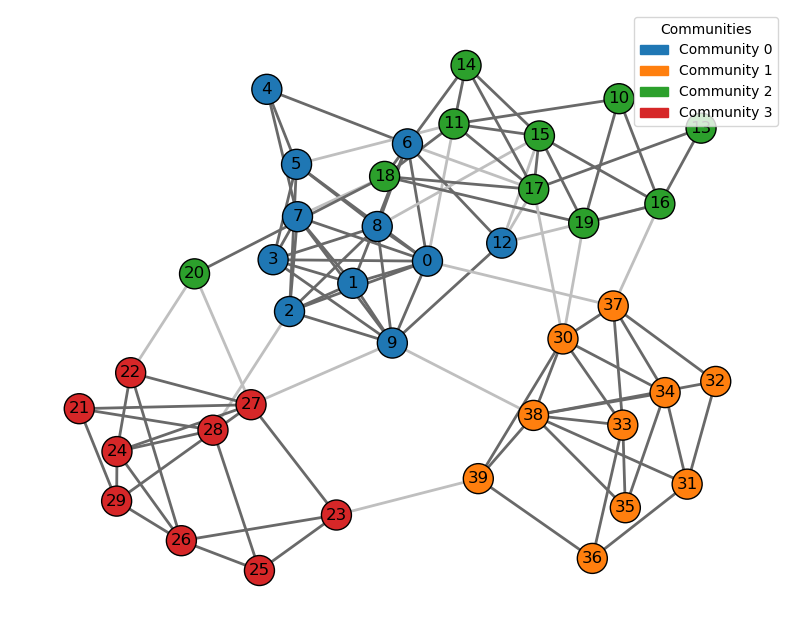

[0.5653061224489797, 0.5898866213151928, 0.5898866213151928, 0.5898866213151928, 0.5898866213151928, 0.5898866213151928]


In [8]:
communities = g.community_leiden(objective_function="modularity", initial_membership=random_membership, n_iterations=1)
modularities = [communities.modularity]
ig_plot_w_legend(g, communities)
for _ in range(5):
    communities = g.community_leiden(objective_function="modularity", initial_membership=communities.membership, n_iterations=1)
    modularities.append(communities.modularity)
print(modularities)